In [82]:
#import packages for machine learning and data manipulation
import pandas as pd
import numpy as np
import seaborn as sns
import random
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

In [108]:
#read data and then drop last column
wi_bcd = pd.read_csv('~/Documents/UCLA_Data_Science_Course/Capstone/Wisconsin_Breast_Cancer_Data.csv')
wi_bcd = wi_bcd.drop('Unnamed: 32', 1)
wi_bcd.head()

id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

            ...             radius_worst  texture_worst  perimeter_worst  \
0           ...                    25.38          17.33           184.60   
1           ...                    24.99          23.41           158.80   
2           ...                    23.57          25.53           152.50   
3           ...                    14.91          26.50            98.87   
4           ...                    22.54          16.67           152.20   

   area_worst  smoothness_worst  compactness_worst  concavity_worst  \
0      2019.0            0.1622             0.6656           0.7119   
1      1956.0            0.1238             0.1866           0.2416   
2      1709.0            0.1444             0.4245           0.4504   
3       567.7            0.2098             0.8663           0.6869   
4      1575.0            0.1374             0.2050           0.4000   

   concave points_worst  symmetry_worst  fractal_dimension_worst  
0                0.2654          0.4601                  0.11890  
1                0.1860          0.2750                  0.08902  
2                0.2430          0.3613                  0.08758  
3                0.2575          0.6638                  0.17300  
4                0.1625          0.2364                  0.07678  

[5 rows x 32 columns]

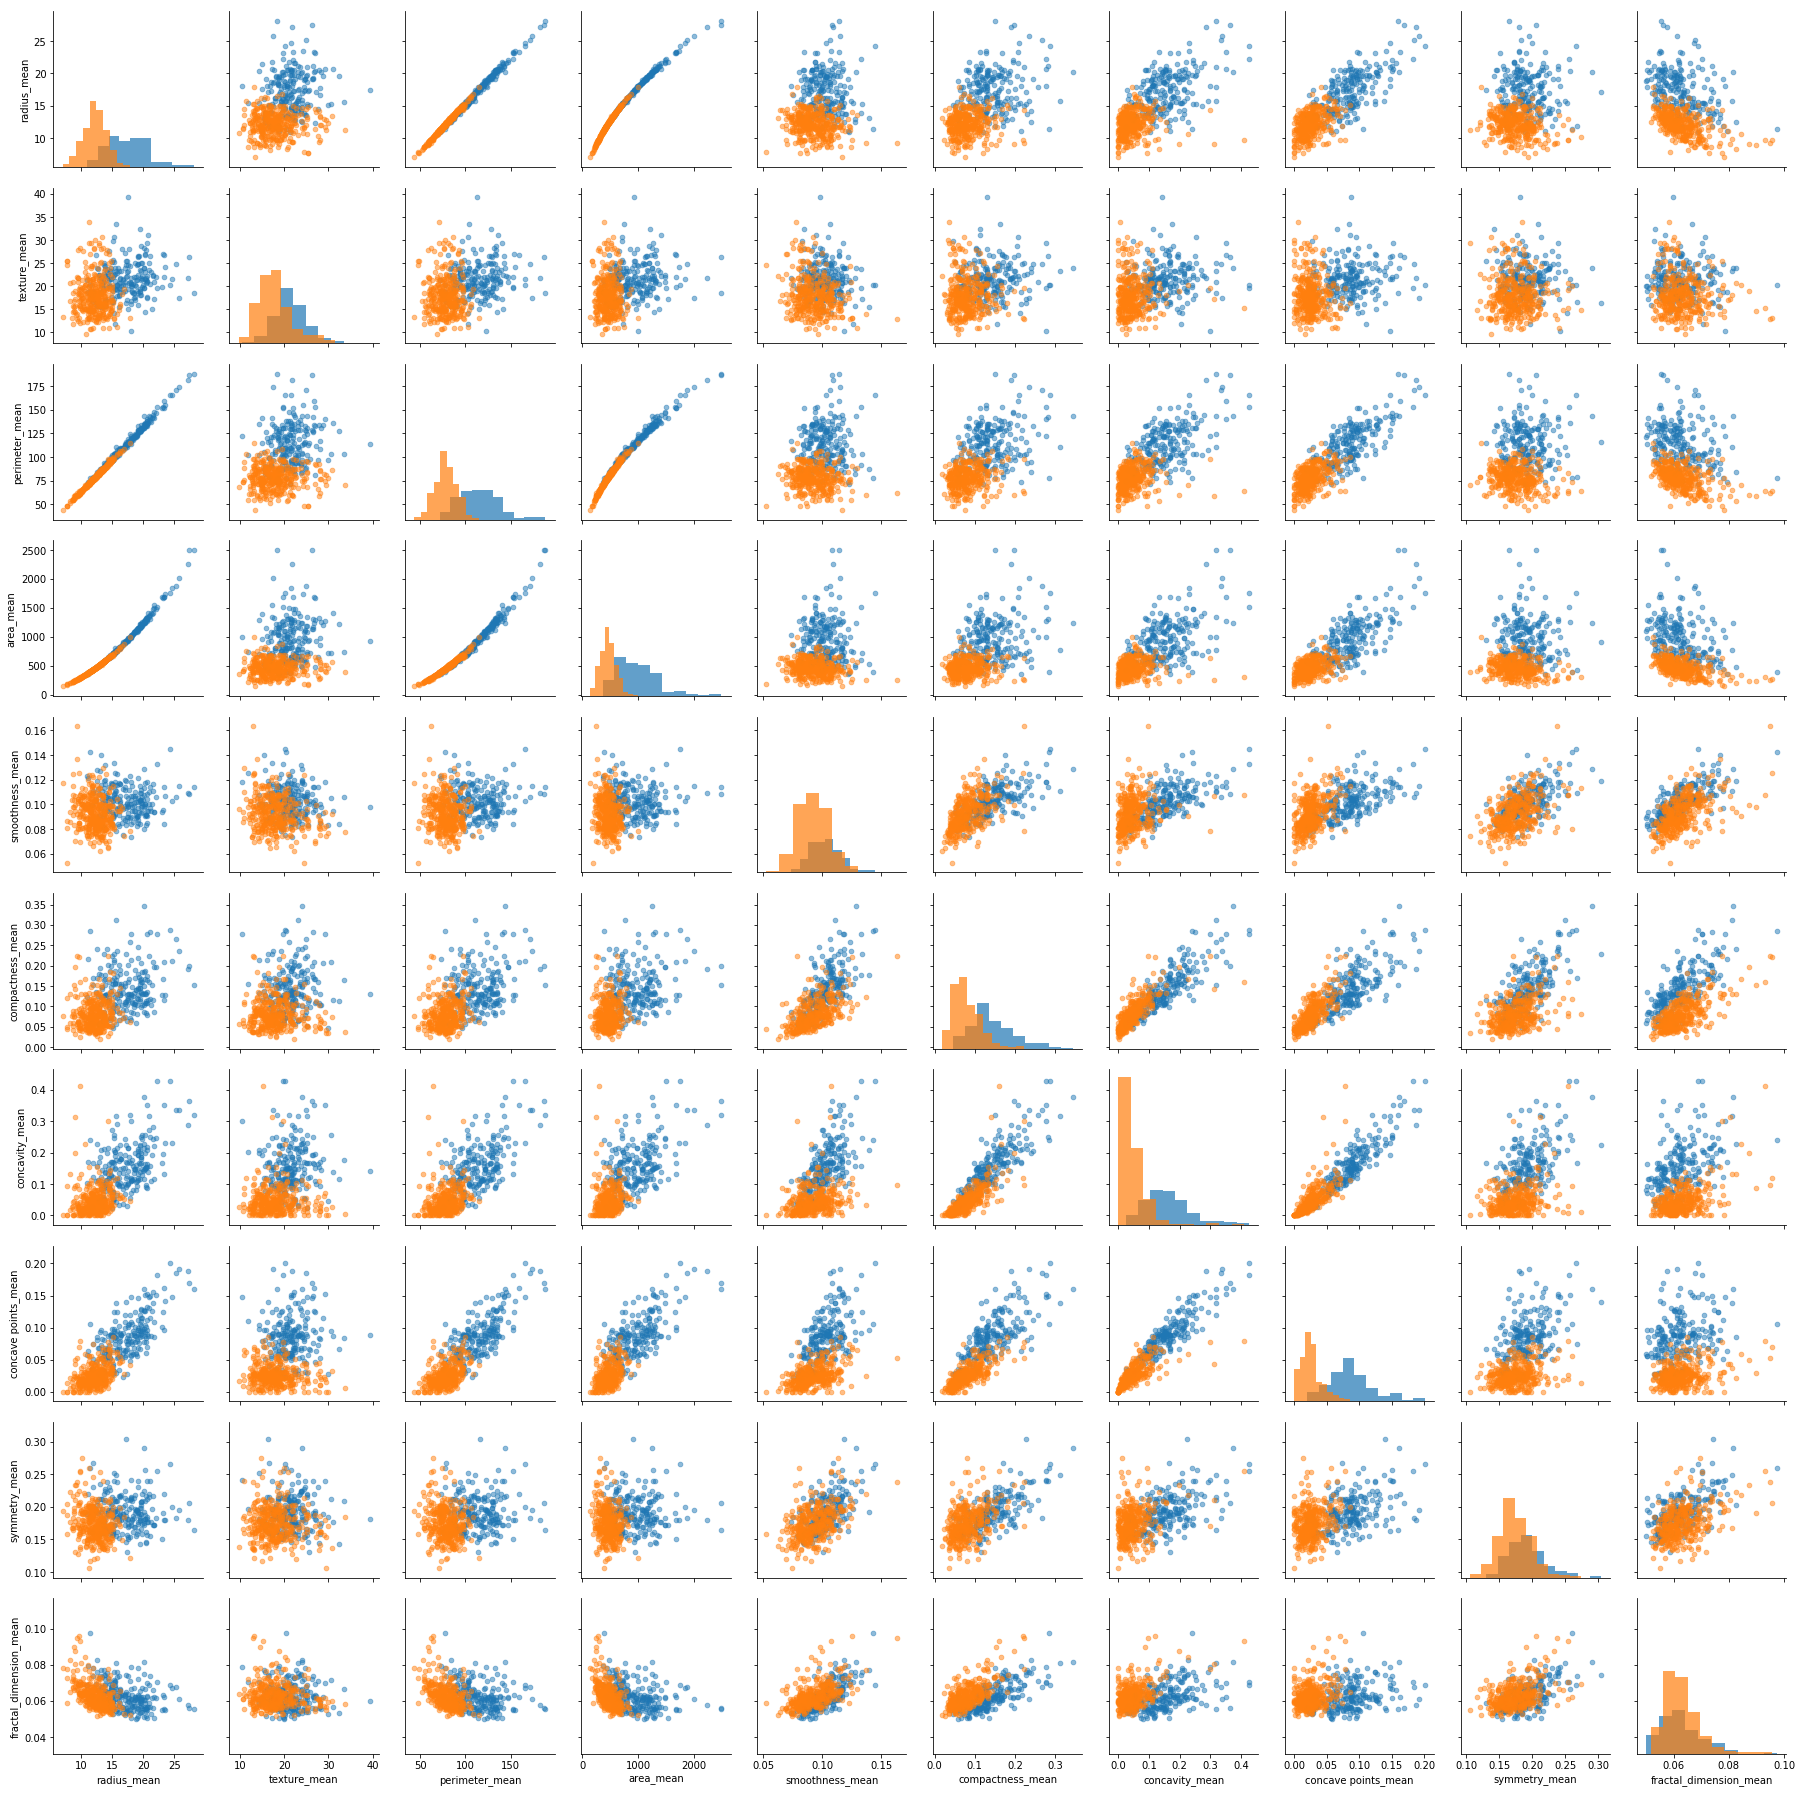

In [3]:
#pair grid to view data for all means
g = sns.PairGrid(wi_bcd.loc[:,'diagnosis':'fractal_dimension_mean'], hue = 'diagnosis')
sns.set_context("paper", rc={"font.size":8,"axes.titlesize":8,"axes.labelsize":20})  
g.map_diag(plt.hist, alpha = 0.7)
g.map_offdiag(plt.scatter, alpha = 0.5);

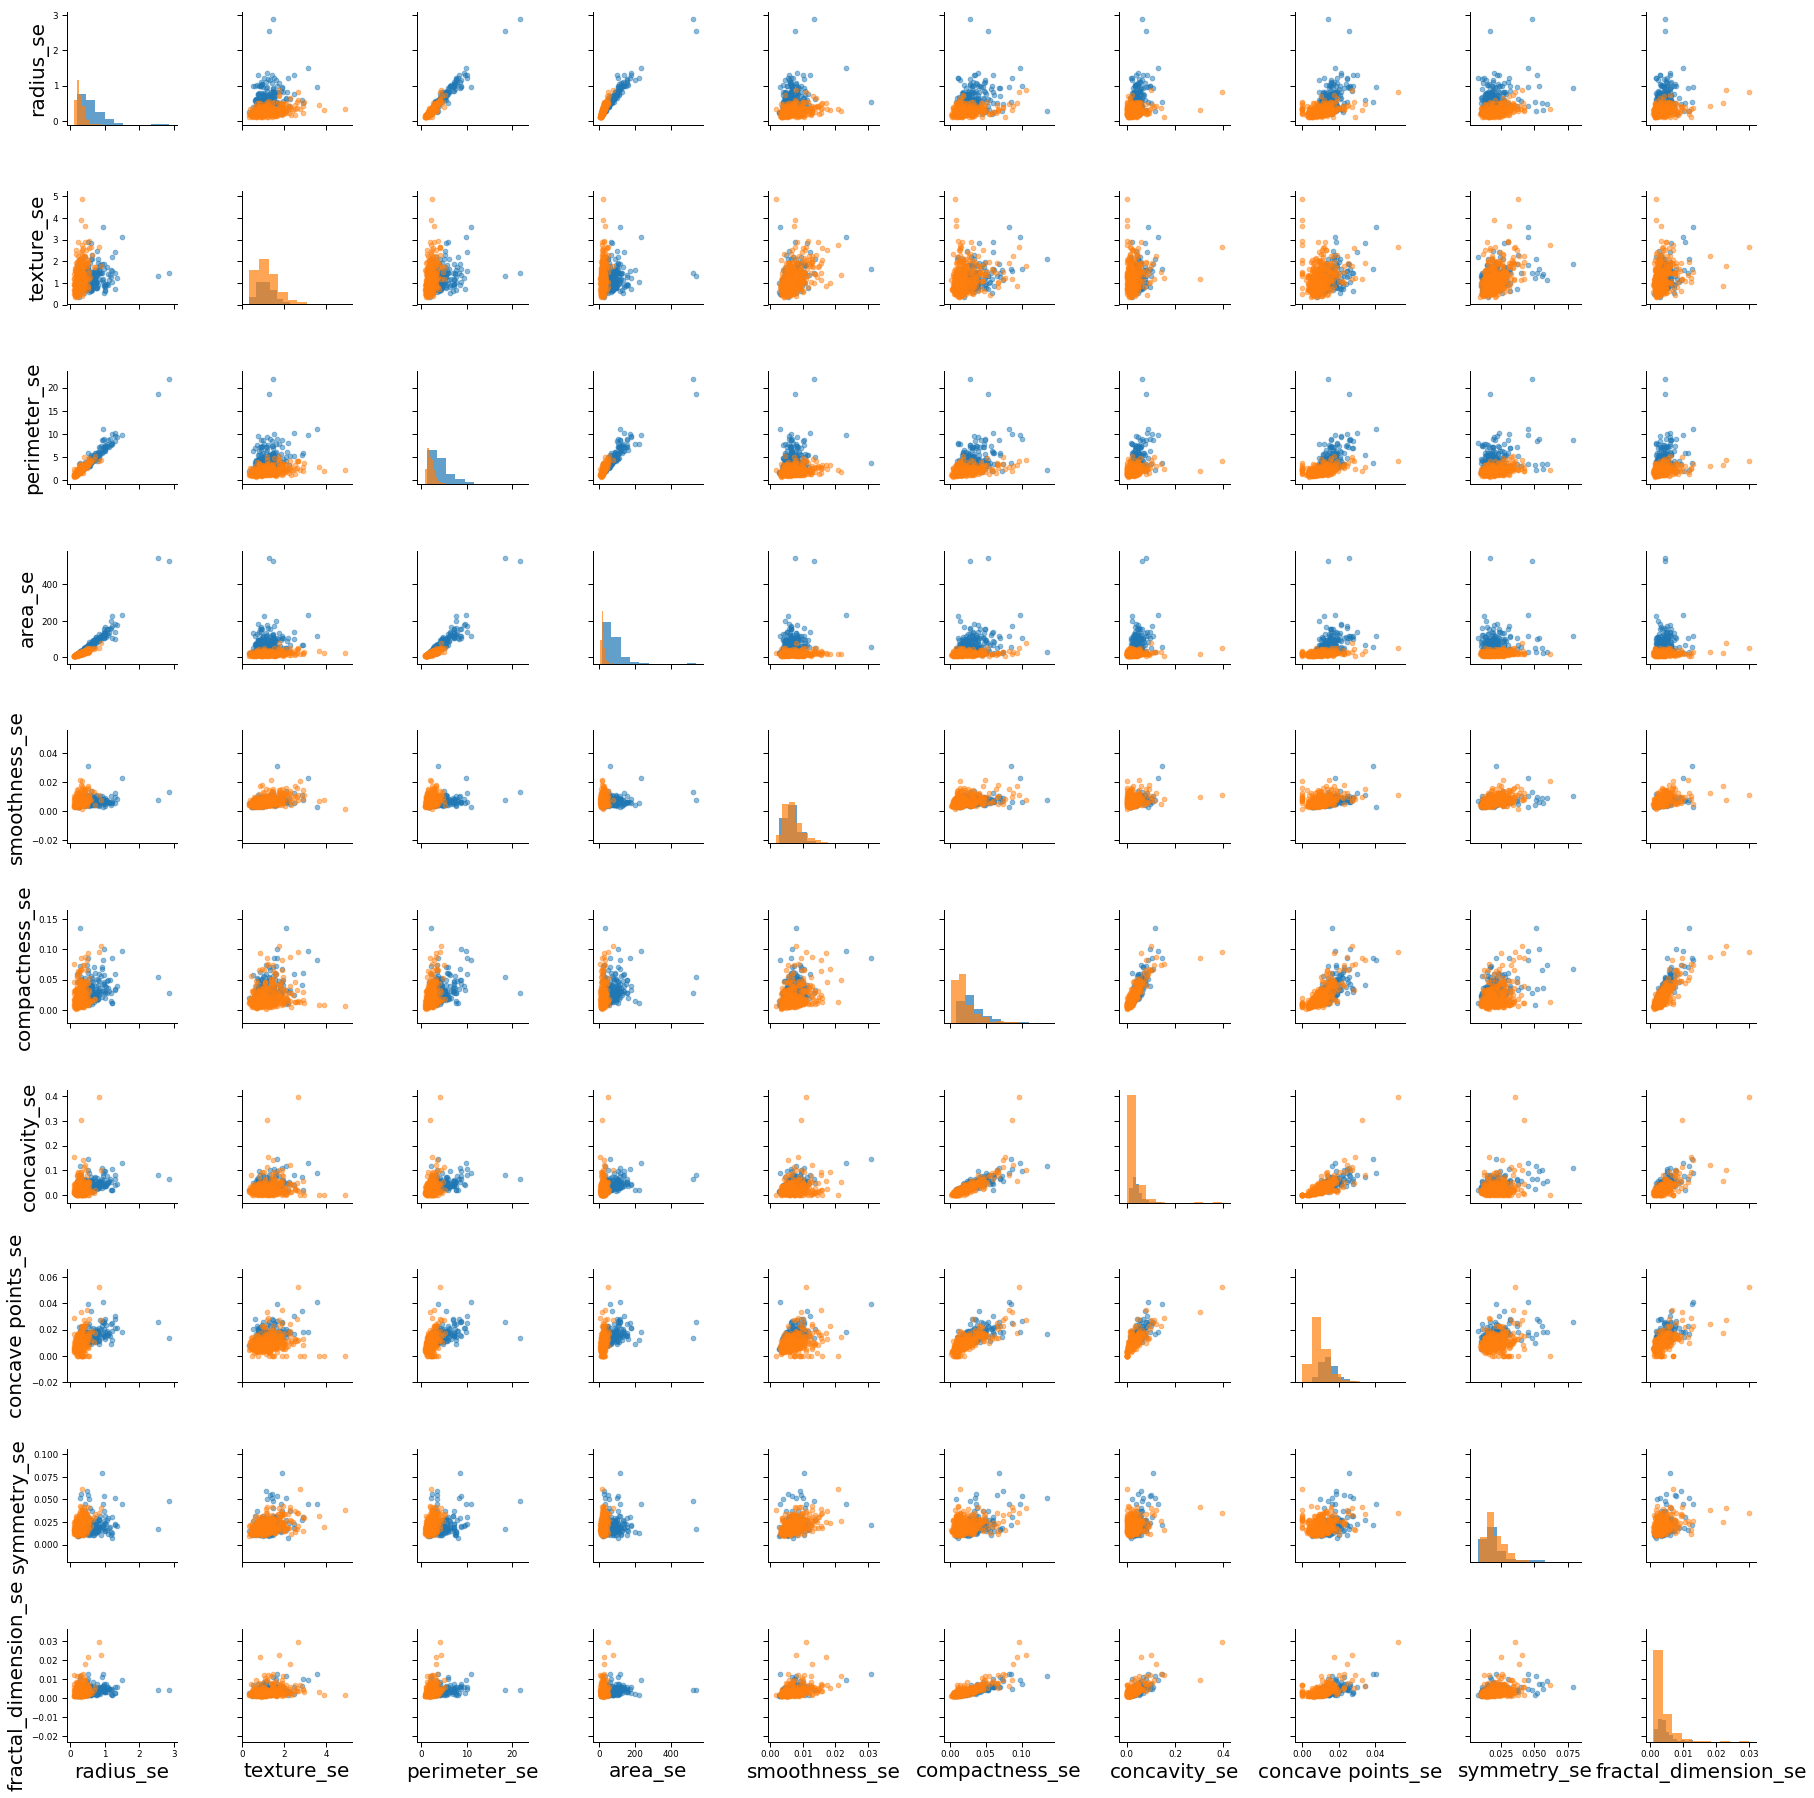

In [4]:
#pair grid to visualize all standard errors
g = sns.PairGrid(wi_bcd[['diagnosis','radius_se', 'texture_se', 'perimeter_se','area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se','symmetry_se', 'fractal_dimension_se']], hue = 'diagnosis')
sns.set_context("paper", rc={"font.size":8,"axes.titlesize":8,"axes.labelsize":20})  
g.map_diag(plt.hist, alpha = 0.7)
g.map_offdiag(plt.scatter, alpha = 0.5);

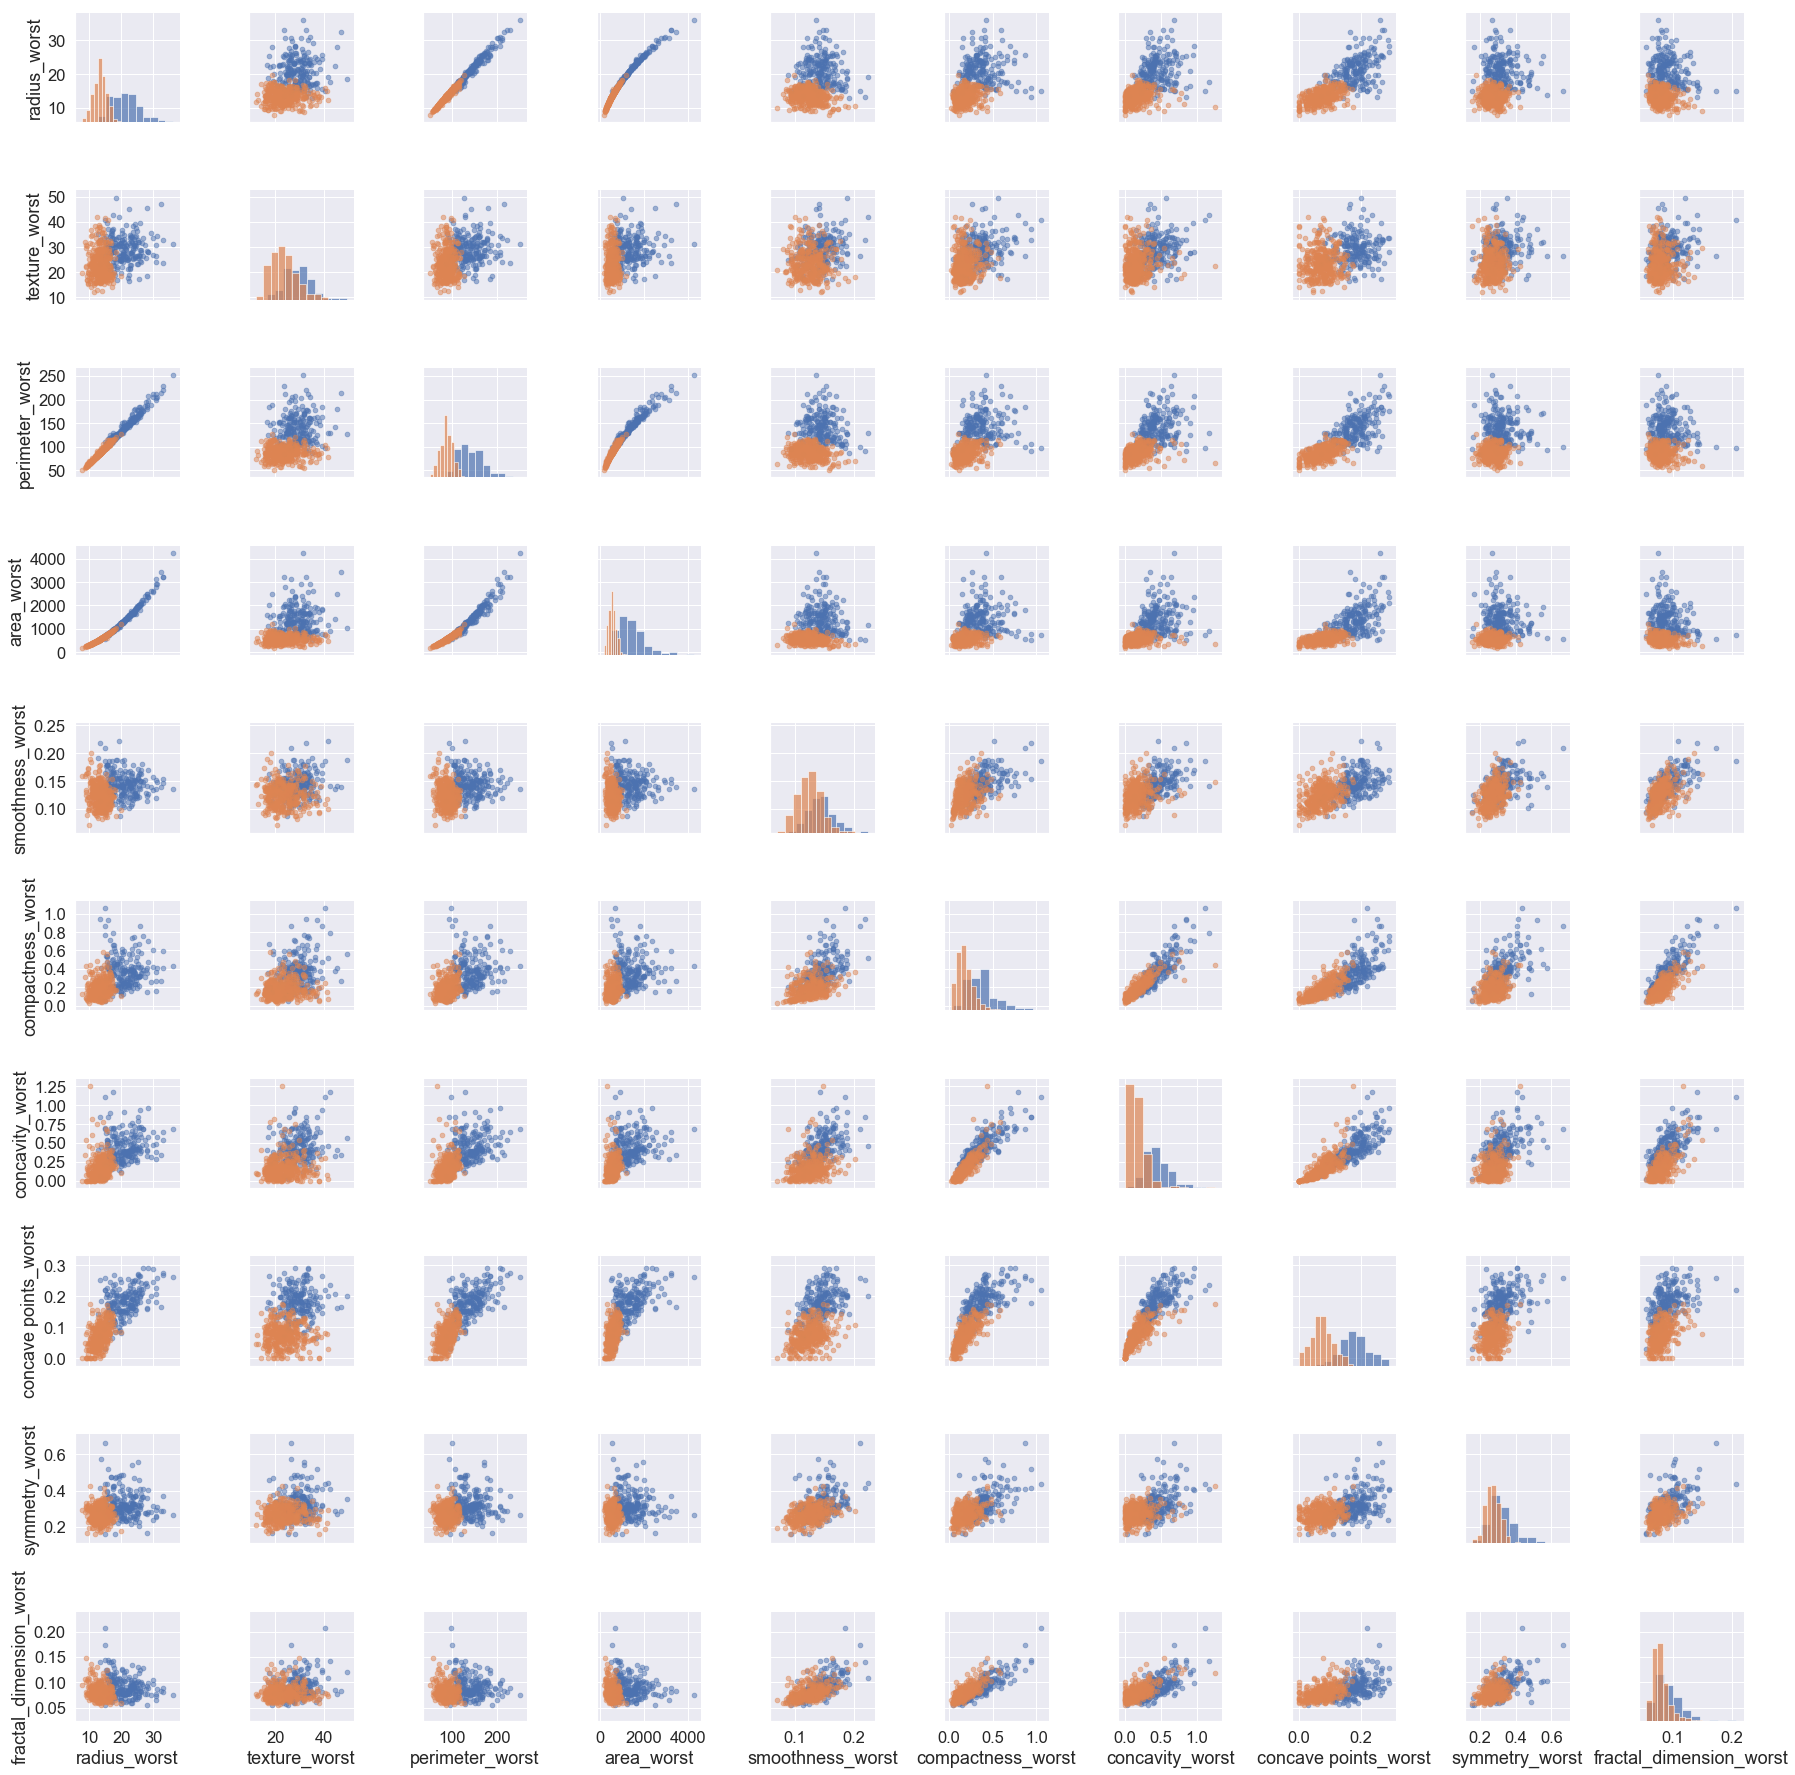

In [75]:
#pair grid to visualize all worst values
g= sns.PairGrid(wi_bcd[['diagnosis','radius_worst', 'texture_worst', 'perimeter_worst','area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst','symmetry_worst', 'fractal_dimension_worst']], hue = 'diagnosis')
sns.set_context("paper", rc={"font.size":8,"axes.titlesize":8,"axes.labelsize":20})  
g.map_diag(plt.hist, alpha = 0.7)
g.map_offdiag(plt.scatter, alpha = 0.5);

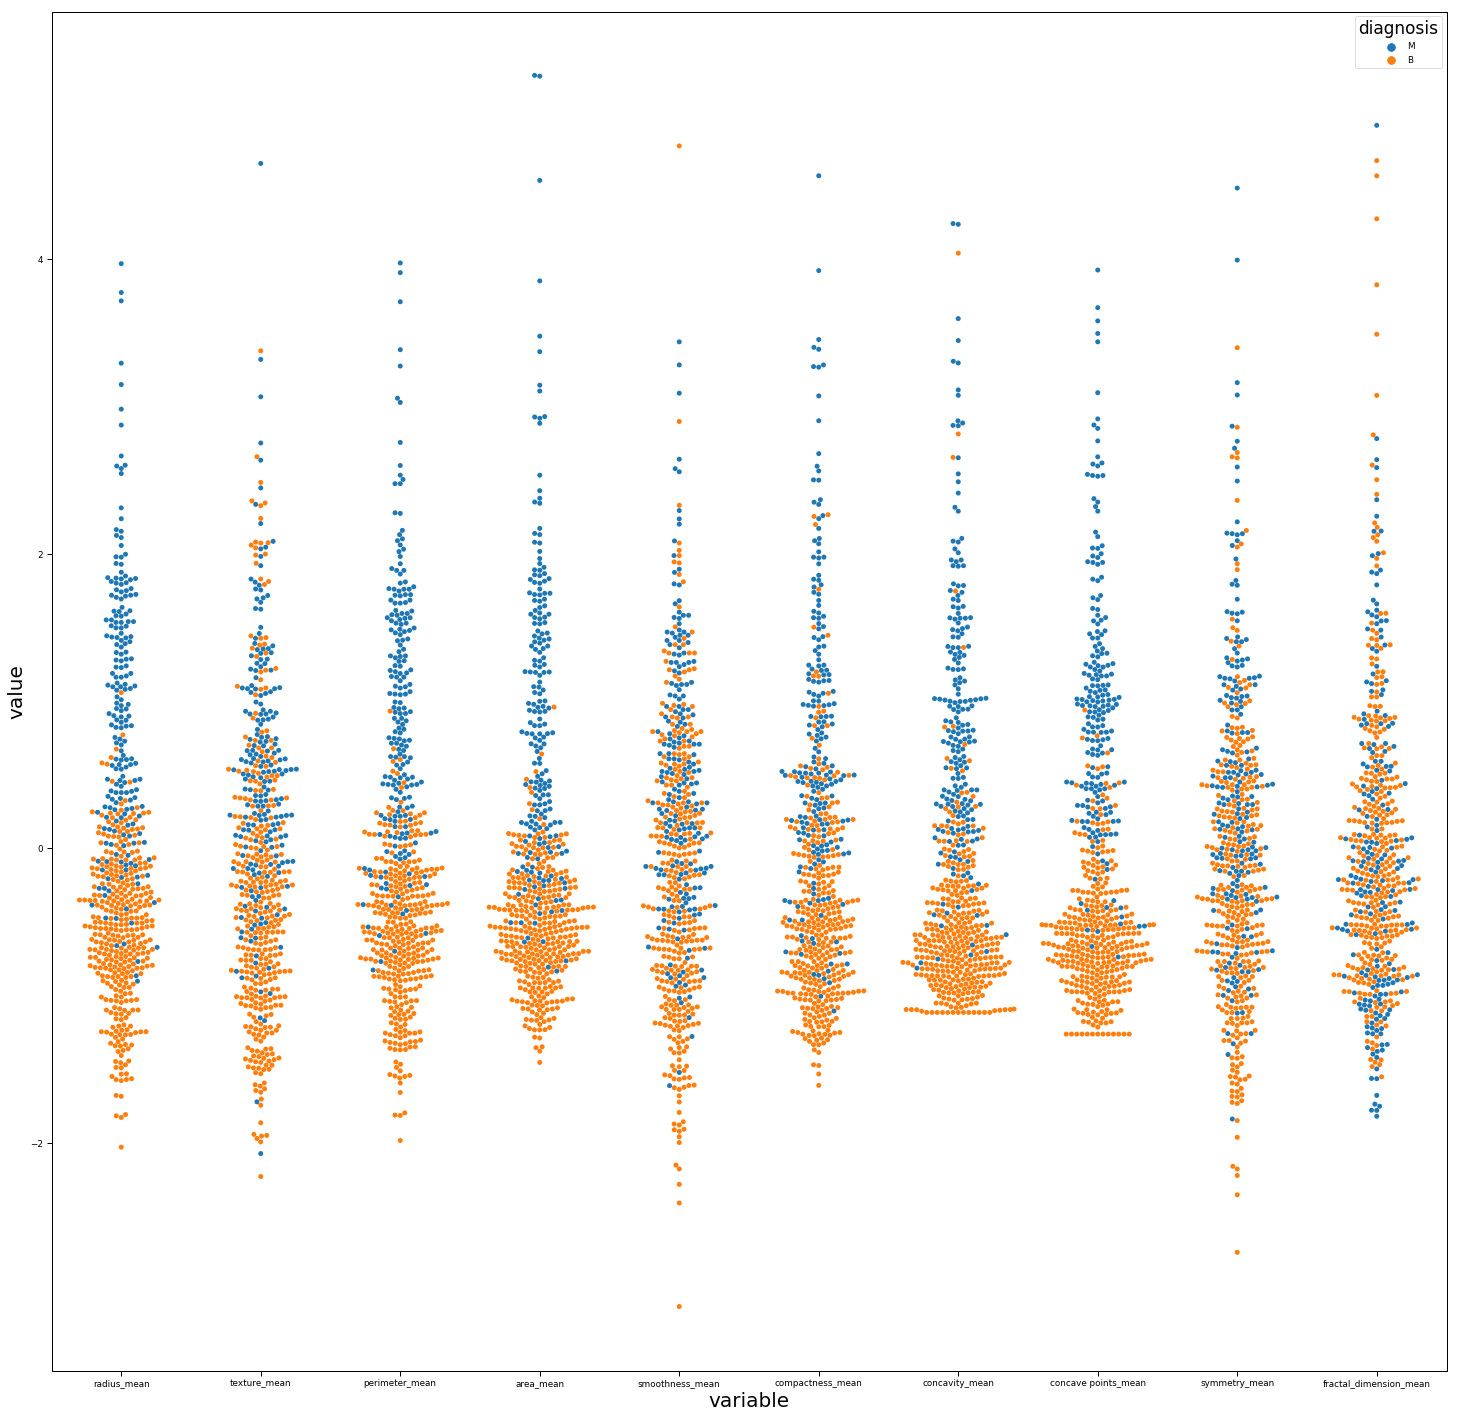

In [7]:
#melt and standardize all data to get swarmplot for the mean values
wi_bcd_mean = wi_bcd.loc[:,'radius_mean':'fractal_dimension_mean']
stan_wi_bcd_mean = (wi_bcd_mean - wi_bcd_mean.mean())/wi_bcd_mean.std()
stan_wi_bcd_mean['diagnosis'] = wi_bcd['diagnosis']
melt_data4 = pd.melt(stan_wi_bcd_mean, id_vars = 'diagnosis')

plt.figure(figsize = (25,25))
sns.swarmplot(x="variable", y="value", hue="diagnosis", data=melt_data4)


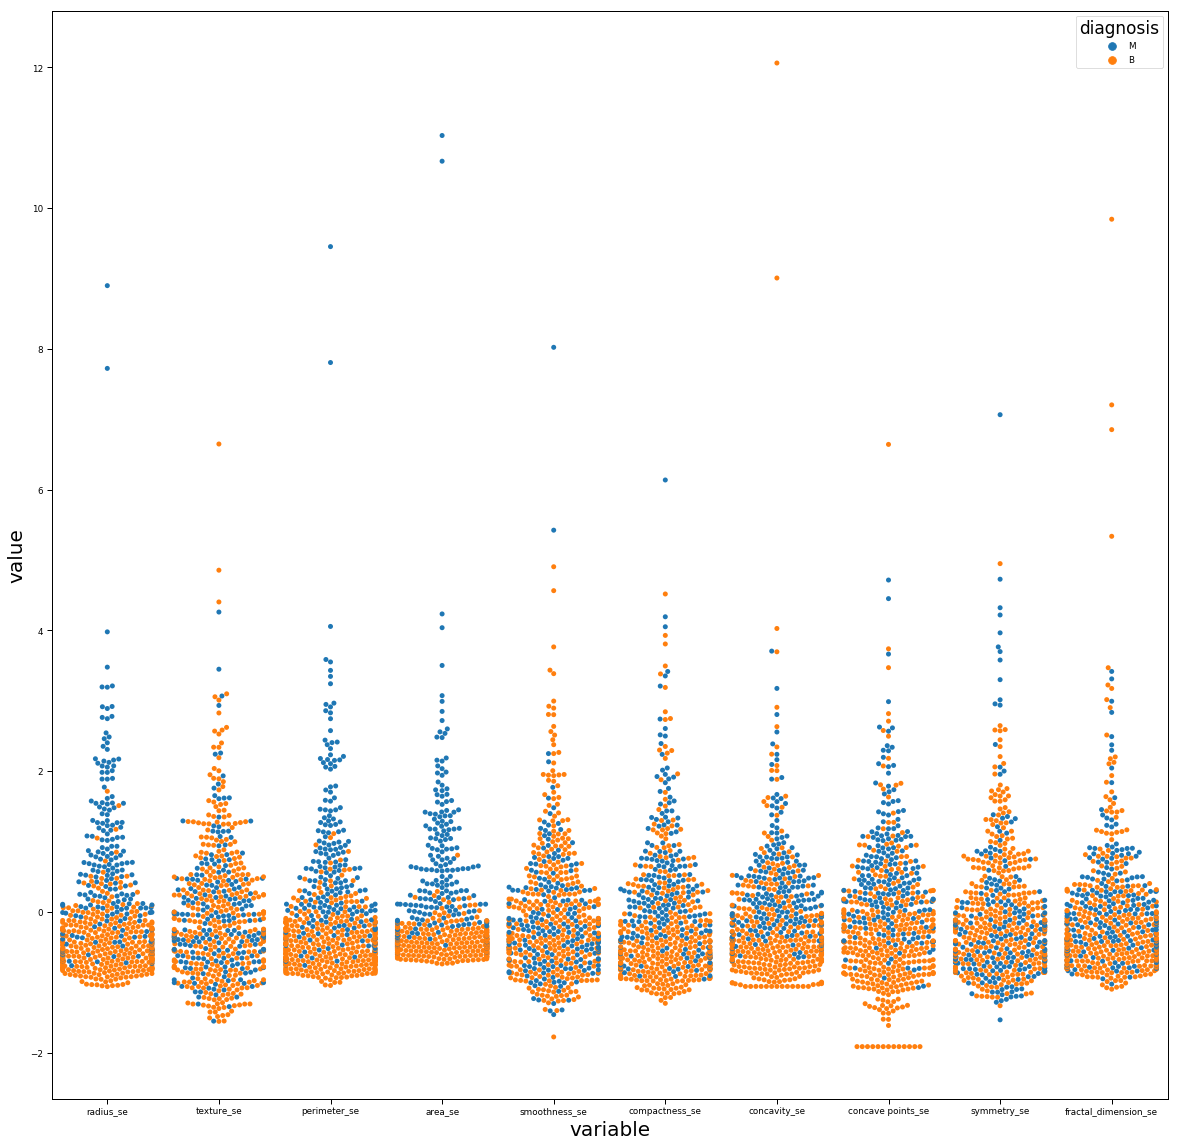

In [5]:
#melt and standardize all data to get swarmplot for the standard error values
wi_bcd_se = wi_bcd.loc[:,'radius_se':'fractal_dimension_se']
stan_wi_bcd_se = (wi_bcd_se - wi_bcd_se.mean())/wi_bcd_se.std()
stan_wi_bcd_se['diagnosis'] = wi_bcd['diagnosis']
melt_data5 = pd.melt(stan_wi_bcd_se, id_vars = 'diagnosis')

plt.figure(figsize = (20,20))
sns.swarmplot(x="variable", y="value", hue="diagnosis", data=melt_data5)


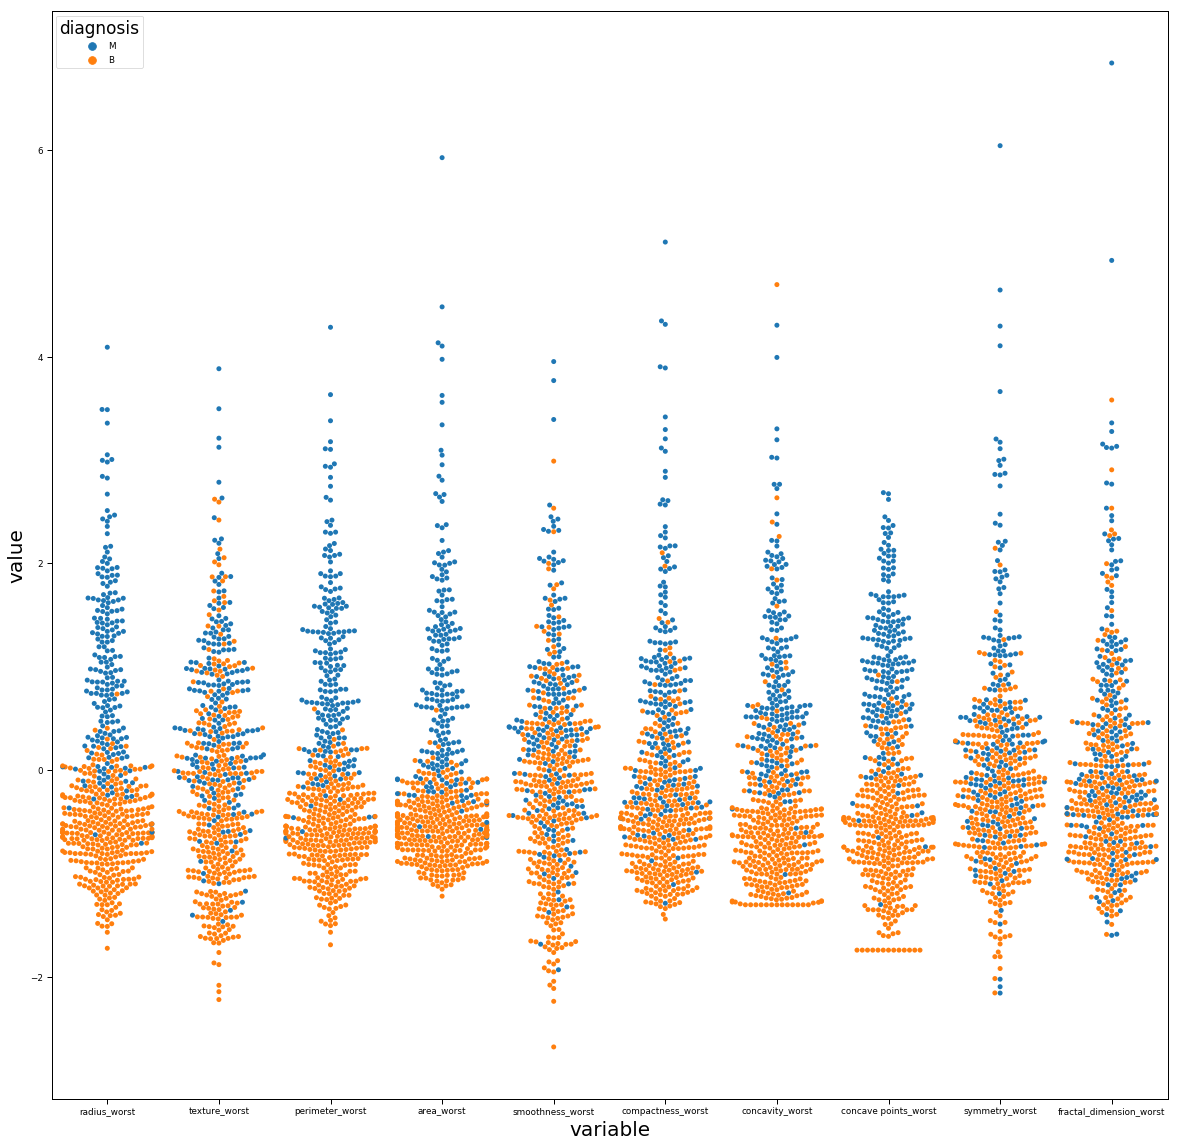

In [6]:
#melt and standardize all data to get swarmplot for the worst values
wi_bcd_worst = wi_bcd.loc[:,'radius_worst':'fractal_dimension_worst']
stan_wi_bcd_worst = (wi_bcd_worst - wi_bcd_worst.mean())/wi_bcd_worst.std()
stan_wi_bcd_worst['diagnosis'] = wi_bcd['diagnosis']
melt_data4 = pd.melt(stan_wi_bcd_worst, id_vars = 'diagnosis')

plt.figure(figsize = (20,20))
sns.swarmplot(x="variable", y="value", hue="diagnosis", data=melt_data4)


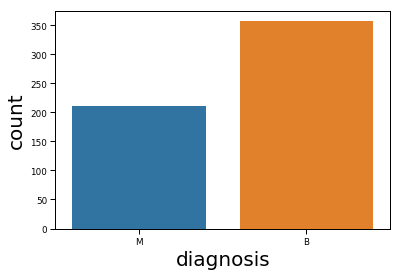

In [8]:
#county of malignant and benign to see the proportion of counts in the complete data set
sns.countplot(wi_bcd['diagnosis'], label = 'count')

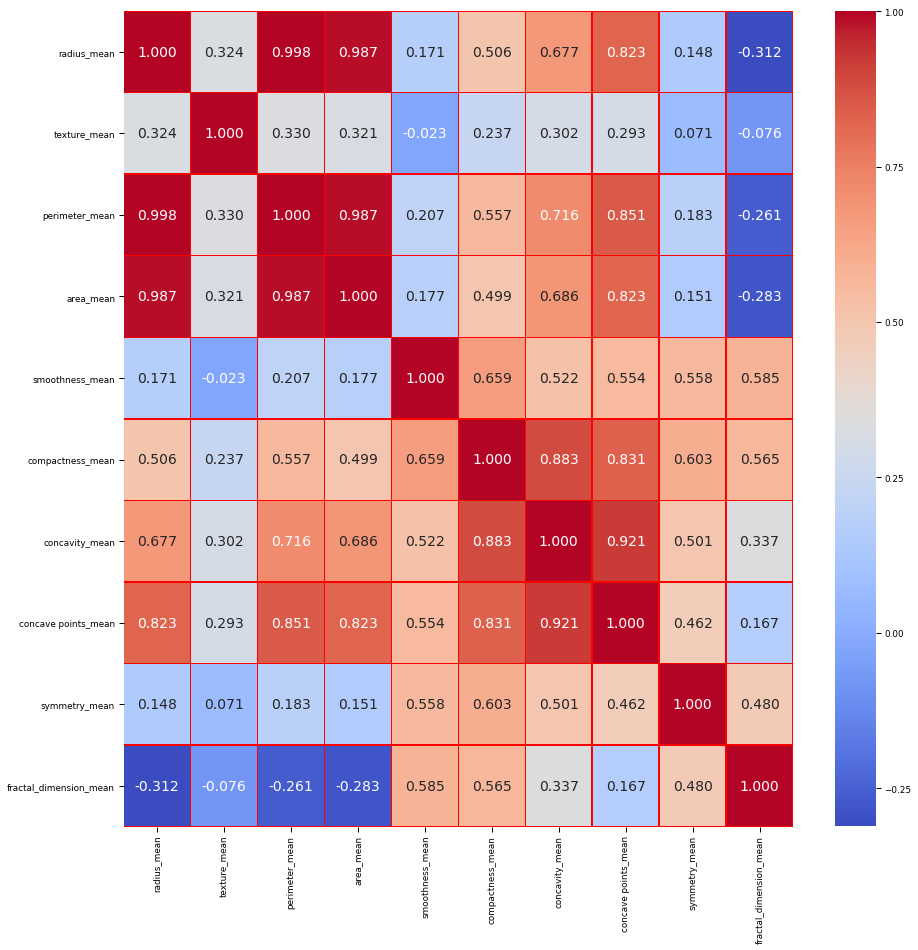

In [9]:
#Correlation Table heatmap for mean values
corr = wi_bcd.loc[:,'diagnosis':'fractal_dimension_mean'].corr()


f, ax = plt.subplots(figsize = (15,15))
sns.heatmap(corr, xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, cmap="coolwarm", annot = True, fmt= '.3f',annot_kws={'size': 14}, ax = ax, linewidths = 0.5, linecolor = 'red')

[0.8947368421052632, 0.9122807017543859, 0.9122807017543859, 0.9181286549707602, 0.9064327485380117, 0.9064327485380117, 0.9064327485380117, 0.9122807017543859]
Accuracy: 0.9122807017543859
Feature ranking:
1. feature 4 (0.324278)
2. feature 3 (0.271301)
3. feature 0 (0.222403)
4. feature 2 (0.087300)
5. feature 5 (0.032085)
6. feature 1 (0.031346)
7. feature 6 (0.031287)


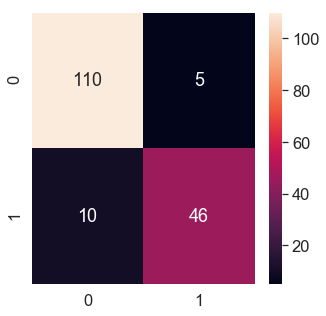

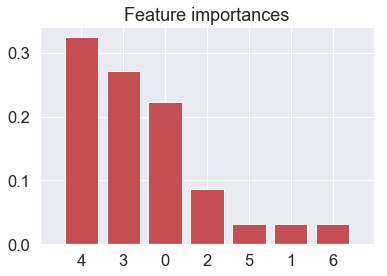

In [132]:
#test train for random forest
train, test = train_test_split(wi_bcd, test_size = 0.3)
pred_variables = ['radius_mean', 'smoothness_mean', 'compactness_mean','concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean']
train_X = train[pred_variables]
train_y = train.diagnosis
test_X = test[pred_variables]
test_y = test.diagnosis

accuracy_list = []
#determine the maximum depth for best accuracy
for i in range(2,10):
    model = RandomForestClassifier(n_estimators = 100, max_depth = i, random_state = 2)
    model = model.fit(train_X, train_y)
    predict = model.predict(test_X)
    accuracy = metrics.accuracy_score(test_y, predict)
    accuracy_list.append(accuracy)
    
ind = accuracy_list.index(max(accuracy_list))
print(accuracy_list)   
model = RandomForestClassifier(n_estimators = 100, max_depth = ind + 1, random_state = 2)
model = model.fit(train_X, train_y)
predict = model.predict(test_X)
accuracy = metrics.accuracy_score(test_y, predict)
print('Accuracy: ' + str(accuracy))

#plot confusion matrix
cm = confusion_matrix(test_y,predict)
plt.figure(figsize=(5,5))
sns.set(font_scale=1.5)
sns.heatmap(cm,annot=True,fmt="d")

#plot feature importance
importances = model.feature_importances_
std = np.std([model.feature_importances_ for tree in model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(train_X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(train_X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")


plt.xticks(range(train_X.shape[1]), indices)
plt.xlim([-1, train_X.shape[1]])
plt.show()

[0.8947368421052632, 0.9122807017543859, 0.9064327485380117, 0.9122807017543859, 0.9064327485380117, 0.9064327485380117, 0.9005847953216374, 0.9064327485380117]
Accuracy: 0.8947368421052632
Feature ranking:
1. feature 4 (0.355396)
2. feature 3 (0.272169)
3. feature 0 (0.215229)
4. feature 2 (0.094209)
5. feature 5 (0.030381)
6. feature 1 (0.020652)
7. feature 6 (0.011965)


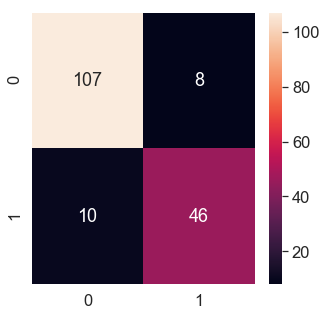

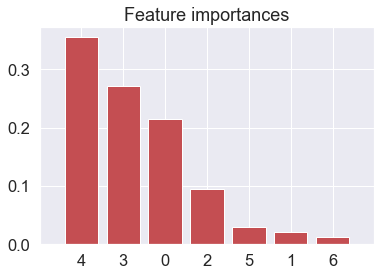

In [133]:
#try perimeter instead of radius, do the same test for random forest
pred_variables = ['perimeter_mean', 'smoothness_mean', 'compactness_mean','concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean']
train_X = train[pred_variables]
train_y = train.diagnosis
test_X = test[pred_variables]
test_y = test.diagnosis

accuracy_list = []
for i in range(2,10):
    model = RandomForestClassifier(n_estimators = 100, max_depth = i, random_state = 2)
    model = model.fit(train_X, train_y)
    predict = model.predict(test_X)
    accuracy = metrics.accuracy_score(test_y, predict)
    accuracy_list.append(accuracy)
print(accuracy_list)
ind = accuracy_list.index(max(accuracy_list))
    
model = RandomForestClassifier(n_estimators = 100, max_depth = ind + 1, random_state = 2)
model = model.fit(train_X, train_y)
predict = model.predict(test_X)
accuracy = metrics.accuracy_score(test_y, predict)
print('Accuracy: ' + str(accuracy))

cm = confusion_matrix(test_y,predict)
plt.figure(figsize=(5,5))
sns.set(font_scale=1.5)
sns.heatmap(cm,annot=True,fmt="d")


importances = model.feature_importances_
std = np.std([model.feature_importances_ for tree in model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(train_X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(train_X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")


plt.xticks(range(train_X.shape[1]), indices)
plt.xlim([-1, train_X.shape[1]])
plt.show()

[0.8947368421052632, 0.9122807017543859, 0.9122807017543859, 0.9064327485380117, 0.9122807017543859, 0.9122807017543859, 0.9064327485380117, 0.9122807017543859]
Accuracy: 0.8947368421052632
Feature ranking:
1. feature 4 (0.358672)
2. feature 3 (0.278114)
3. feature 0 (0.204400)
4. feature 2 (0.094689)
5. feature 5 (0.030253)
6. feature 1 (0.021642)
7. feature 6 (0.012229)


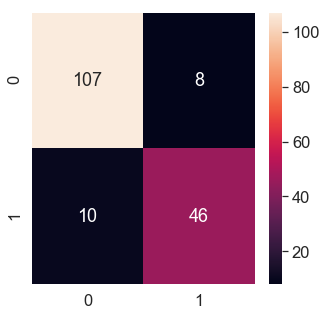

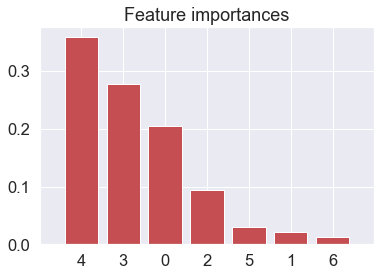

In [134]:
#try area instead of perimeter, do the same test for random forest
pred_variables = ['area_mean', 'smoothness_mean', 'compactness_mean','concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean']
train_X = train[pred_variables]
train_y = train.diagnosis
test_X = test[pred_variables]
test_y = test.diagnosis

accuracy_list = []
for i in range(2,10):
    model = RandomForestClassifier(n_estimators = 100, max_depth = i, random_state = 2)
    model = model.fit(train_X, train_y)
    predict = model.predict(test_X)
    accuracy = metrics.accuracy_score(test_y, predict)
    accuracy_list.append(accuracy)
print(accuracy_list)
ind = accuracy_list.index(max(accuracy_list))
    
model = RandomForestClassifier(n_estimators = 100, max_depth = ind + 1, random_state = 2)
model = model.fit(train_X, train_y)
predict = model.predict(test_X)
accuracy = metrics.accuracy_score(test_y, predict)
print('Accuracy: ' + str(accuracy))

cm = confusion_matrix(test_y,predict)
plt.figure(figsize=(5,5))
sns.set(font_scale=1.5)
sns.heatmap(cm,annot=True,fmt="d")


importances = model.feature_importances_
std = np.std([model.feature_importances_ for tree in model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(train_X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(train_X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")


plt.xticks(range(train_X.shape[1]), indices)
plt.xlim([-1, train_X.shape[1]])
plt.show()

[0.9005847953216374, 0.9181286549707602, 0.9122807017543859, 0.9064327485380117, 0.9122807017543859, 0.9122807017543859, 0.9064327485380117, 0.9122807017543859]
Accuracy: 0.9181286549707602


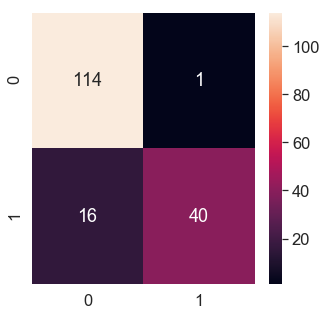

In [137]:
#KNN model now, try to find the best accuracy for nearest neighbors up to 10
pred_variables = ['radius_mean', 'smoothness_mean', 'compactness_mean','concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean']
train_X = train[pred_variables]
train_y = train.diagnosis
test_X = test[pred_variables]
test_y = test.diagnosis

accuracy_list = []
for i in range(2,10):
    model = KNeighborsClassifier(n_neighbors=i)
    model = model.fit(train_X, train_y)
    predict = model.predict(test_X)
    accuracy = metrics.accuracy_score(test_y, predict)
    accuracy_list.append(accuracy)

max_index = accuracy_list.index(max(accuracy_list))
print(accuracy_list)

model = KNeighborsClassifier(n_neighbors = max_index + 1)
model = model.fit(train_X, train_y)
predict = model.predict(test_X)
print('Accuracy: ' + str(accuracy_list[max_index]))
    
cm = confusion_matrix(test_y,predict)
plt.figure(figsize=(5,5))
sns.set(font_scale=1.5)
sns.heatmap(cm,annot=True,fmt="d")


0
[0.8713450292397661, 0.8713450292397661, 0.8596491228070176, 0.8538011695906432, 0.8654970760233918, 0.8654970760233918, 0.8654970760233918, 0.8421052631578947]
0.8713450292397661


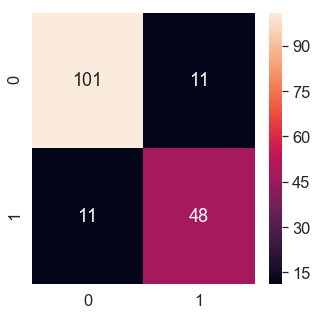

In [101]:
#KNN model now, try to find the best accuracy for nearest neighbors up to 10 for perimeter rather than radius
pred_variables = ['perimeter_mean', 'smoothness_mean', 'compactness_mean','concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean']
train_X = train[pred_variables]
train_y = train.diagnosis
test_X = test[pred_variables]
test_y = test.diagnosis

accuracy_list = []
for i in range(2,10):
    model = KNeighborsClassifier(n_neighbors=i)
    model = model.fit(train_X, train_y)
    predict = model.predict(test_X)
    accuracy = metrics.accuracy_score(test_y, predict)
    accuracy_list.append(accuracy)

max_index = accuracy_list.index(max(accuracy_list))
print(accuracy_list)

model = KNeighborsClassifier(n_neighbors = max_index + 1)
model = model.fit(train_X, train_y)
predict = model.predict(test_X)
print('Accuracy: ' + str(accuracy_list[max_index]))
    
cm = confusion_matrix(test_y,predict)
plt.figure(figsize=(5,5))
sns.set(font_scale=1.5)
sns.heatmap(cm,annot=True,fmt="d")

Accuracy: 0.8888888888888888


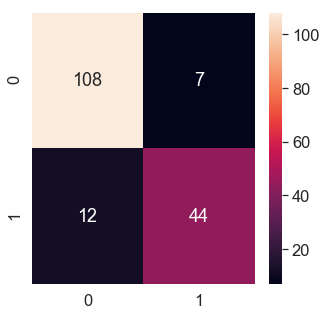

In [151]:
#KNN model now, try to find the best accuracy for nearest neighbors up to 10 for area rather than perimeter
pred_variables = ['area_mean', 'smoothness_mean', 'compactness_mean','concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean']
train_X = train[pred_variables]
train_y = train.diagnosis
test_X = test[pred_variables]
test_y = test.diagnosis

accuracy_list = []
for i in range(2,10):
    model = KNeighborsClassifier(n_neighbors=i)
    model = model.fit(train_X, train_y)
    predict = model.predict(test_X)
    accuracy = metrics.accuracy_score(test_y, predict)
    accuracy_list.append(accuracy)

max_index = accuracy_list.index(max(accuracy_list))
print(accuracy_list)

model = KNeighborsClassifier(n_neighbors = max_index + 1)
model = model.fit(train_X, train_y)
predict = model.predict(test_X)
print('Accuracy: ' + str(accuracy_list[max_index]))
    
cm = confusion_matrix(test_y,predict)
plt.figure(figsize=(5,5))
sns.set(font_scale=1.5)
sns.heatmap(cm,annot=True,fmt="d")

In [ ]:
#Naive Bayesian model for means, test for accuracy and see the confusion matrix
pred_variables = ['radius_mean', 'smoothness_mean', 'compactness_mean','concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean']
train_X = train[pred_variables]
train_y = train.diagnosis
test_X = test[pred_variables]
test_y = test.diagnosis

model = GaussianNB()
model = model.fit(train_X, train_y)
predict = model.predict(test_X)
accuracy = metrics.accuracy_score(test_y, predict)
print('Accuracy: ' + str(accuracy))

cm = confusion_matrix(test_y,predict)
plt.figure(figsize=(5,5))
sns.set(font_scale=1.5)
sns.heatmap(cm,annot=True,fmt="d")

In [149]:
#cross validation scores for 10-fold cross validation
def classification_cross_10(model, data, prediction, out):

    model.fit(data[prediction], data[out])    
    #kFold cross validation
    scores = cross_val_score(model, data[prediction], data[out], cv=10)
    
    print('Accuracy after cross validation: ' + str(scores.mean()) + '+/-' +str(2*scores.std()))
    plt.title('Cross Validation Accuracy of Model')
    plt.xlabel('Cross Validation')
    plt.ylabel('Accuracy')
    plt.plot(range(1,len(scores)+1), scores)
    

Accuracy after cross validation: 0.9284266701235847+/-0.11350798805965412


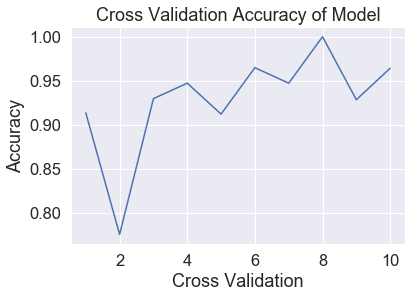

In [150]:
#10 fold cross validation for random forest
pred_variables = ['radius_mean', 'smoothness_mean', 'compactness_mean','concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean']
outcome_varb = 'diagnosis'
model = RandomForestClassifier(n_estimators = 100, random_state = 1)
classification_cross_10(model, wi_bcd, pred_variables, outcome_varb)

In Sample Accuracy: 0.9490333919156415
Accuracy after cross validation: 0.9350769164290036+/-0.04020642572216314


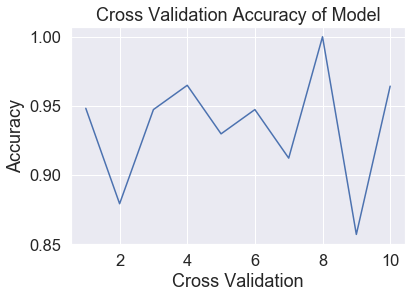

In [141]:
#10 fold cross validation for knn
pred_variables = ['radius_mean', 'smoothness_mean', 'compactness_mean','concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean']
outcome_varb = 'diagnosis'
model =  KNeighborsClassifier()
classification_cross_10(model, stan_wi_bcd_mean, pred_variables, outcome_varb)

In Sample Accuracy: 0.9068541300527241
Accuracy after cross validation: 0.9088486301961801+/-0.03513008967274725


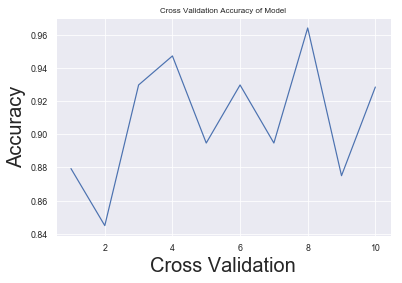

In [88]:
#10 fold cross validation for naive bayesian
pred_variables = ['radius_mean', 'smoothness_mean', 'compactness_mean','concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean']
outcome_varb = 'diagnosis'
model =  GaussianNB()
classification_cross_10(model, stan_wi_bcd_mean, pred_variables, outcome_varb)